# Table of Contents
* [1. DDoS Detection on IoT - Unique Model - L5](#1.-DDoS-Detection-on-IoT---Unique-Model---L5)
	* [1.1 Imports](#1.1-Imports)
* [2. Import Datasets and Normalize](#2.-Import-Datasets-and-Normalize)
	* [2.1 Danmini Doorbell](#2.1-Danmini-Doorbell)
	* [2.2 Ecobee Thermostat](#2.2-Ecobee-Thermostat)
	* [2.3 Ennio Doorbell](#2.3-Ennio-Doorbell)
	* [2.4 Philips Baby Monitor](#2.4-Philips-Baby-Monitor)
	* [2.5 Security Camera](#2.5-Security-Camera)
	* [2.6 Security Camera](#2.6-Security-Camera)
	* [2.7 Security Camera](#2.7-Security-Camera)
	* [2.8 Security Camera](#2.8-Security-Camera)
	* [2.9 Samsung Webcam](#2.9-Samsung-Webcam)
* [3. Variational Autoencoder - Attack Detection](#3.-Variational-Autoencoder---Attack-Detection)
	* [3.1 Model](#3.1-Model)
	* [3.2 Train](#3.2-Train)
	* [3.3 Test](#3.3-Test)
	* [3.4 Metrics](#3.4-Metrics)


# 1. DDoS Detection on IoT - Unique Model - L5 - 115 Features - VAE

## 1.1 Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
import time
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# 2. Import Datasets and Normalize

## 2.1 Danmini Doorbell

In [2]:
# Benign traffic

dd_benign = pd.read_csv('nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

chosen_columns = list(df_dd_benign.columns)
'''
columns = list(df_dd_benign.columns)
chosen_columns = []

for column in columns:
    if column.find('L5') != -1:             # selecionando apenas intervalo L5 (100 ms)
        chosen_columns.append(column)

df_dd_benign = pd.DataFrame(df_dd_benign, columns = chosen_columns)
'''

# Mirai attacks
dd_mirai_ack = pd.read_csv('nbaiot/Danmini_Doorbell/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)
df_dd_mirai_ack = pd.DataFrame(df_dd_mirai_ack, columns = chosen_columns)

dd_mirai_scan = pd.read_csv('nbaiot/Danmini_Doorbell/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)
df_dd_mirai_scan = pd.DataFrame(df_dd_mirai_scan, columns = chosen_columns)

dd_mirai_syn = pd.read_csv('nbaiot/Danmini_Doorbell/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)
df_dd_mirai_syn = pd.DataFrame(df_dd_mirai_syn, columns = chosen_columns)

dd_mirai_udp = pd.read_csv('nbaiot/Danmini_Doorbell/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)
df_dd_mirai_udp = pd.DataFrame(df_dd_mirai_udp, columns = chosen_columns)

dd_mirai_udpplain = pd.read_csv('nbaiot/Danmini_Doorbell/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)
df_dd_mirai_udpplain = pd.DataFrame(df_dd_mirai_udpplain, columns = chosen_columns)

# Bashlite attacks
dd_bashlite_combo = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)
df_dd_bashlite_combo = pd.DataFrame(df_dd_bashlite_combo, columns = chosen_columns)

dd_bashlite_junk = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)
df_dd_bashlite_junk = pd.DataFrame(df_dd_bashlite_junk, columns = chosen_columns)

dd_bashlite_scan = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)
df_dd_bashlite_scan = pd.DataFrame(df_dd_bashlite_scan, columns = chosen_columns)

dd_bashlite_udp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)
df_dd_bashlite_udp = pd.DataFrame(df_dd_bashlite_udp, columns = chosen_columns)

dd_bashlite_tcp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_tcp.copy(deep=True)
df_dd_bashlite_tcp = pd.DataFrame(df_dd_bashlite_tcp, columns = chosen_columns)

In [3]:
df_dd_benign.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,34.095047,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,100.081513,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.000000,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0


In [4]:
scaler = MinMaxScaler()

df_dd_benign_norm = scaler.fit_transform(df_dd_benign)
df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

## 2.2 Ecobee Thermostat

In [5]:
# Benign traffic

et_benign = pd.read_csv('nbaiot/Ecobee_Thermostat/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_et_benign = et_benign.copy(deep=True)
df_et_benign = pd.DataFrame(df_et_benign, columns = chosen_columns)

# Mirai

et_mirai_ack = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_ack = et_mirai_ack.copy(deep=True)
df_et_mirai_ack = pd.DataFrame(df_et_mirai_ack, columns = chosen_columns)

et_mirai_scan = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_scan = et_mirai_scan.copy(deep=True)
df_et_mirai_scan = pd.DataFrame(df_et_mirai_scan, columns = chosen_columns)

et_mirai_syn = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_syn = et_mirai_syn.copy(deep=True)
df_et_mirai_syn = pd.DataFrame(df_et_mirai_syn, columns = chosen_columns)

et_mirai_udp = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udp = et_mirai_udp.copy(deep=True)
df_et_mirai_udp = pd.DataFrame(df_et_mirai_udp, columns = chosen_columns)

et_mirai_udpplain = pd.read_csv('nbaiot/Ecobee_Thermostat/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udpplain = et_mirai_udpplain.copy(deep=True)
df_et_mirai_udpplain = pd.DataFrame(df_et_mirai_udpplain, columns = chosen_columns)

# Bashlite

et_bashlite_combo = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_combo = et_bashlite_combo.copy(deep=True)
df_et_bashlite_combo = pd.DataFrame(df_et_bashlite_combo, columns = chosen_columns)

et_bashlite_junk = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_junk = et_bashlite_junk.copy(deep=True)
df_et_bashlite_junk = pd.DataFrame(df_et_bashlite_junk, columns = chosen_columns)

et_bashlite_scan = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_scan = et_bashlite_scan.copy(deep=True)
df_et_bashlite_scan = pd.DataFrame(df_et_bashlite_scan, columns = chosen_columns)

et_bashlite_udp = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_udp = et_bashlite_udp.copy(deep=True)
df_et_bashlite_udp = pd.DataFrame(df_et_bashlite_udp, columns = chosen_columns)

et_bashlite_tcp = pd.read_csv('nbaiot/Ecobee_Thermostat/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_tcp = et_bashlite_tcp.copy(deep=True)
df_et_bashlite_tcp = pd.DataFrame(df_et_bashlite_tcp, columns = chosen_columns)

In [6]:
df_et_benign_norm = scaler.fit_transform(df_et_benign)

df_et_miraiack_norm = scaler.fit_transform(df_et_mirai_ack)
df_et_miraiscan_norm = scaler.fit_transform(df_et_mirai_scan)
df_et_miraisyn_norm = scaler.fit_transform(df_et_mirai_syn)
df_et_miraiudp_norm = scaler.fit_transform(df_et_mirai_udp)
df_et_miraiudpplain_norm = scaler.fit_transform(df_et_mirai_udpplain)

df_et_bashlitecombo_norm = scaler.fit_transform(df_et_bashlite_combo)
df_et_bashlitejunk_norm = scaler.fit_transform(df_et_bashlite_junk)
df_et_bashlitescan_norm = scaler.fit_transform(df_et_bashlite_scan)
df_et_bashliteudp_norm = scaler.fit_transform(df_et_bashlite_udp)
df_et_bashlitetcp_norm = scaler.fit_transform(df_et_bashlite_tcp)

## 2.3 Ennio Doorbell

In [7]:
# Benign traffic

ed_benign = pd.read_csv('nbaiot/Ennio_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_ed_benign = ed_benign.copy(deep=True)
df_ed_benign = pd.DataFrame(df_ed_benign, columns = chosen_columns)

# Only Bashlite

ed_bashlite_combo = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_combo = ed_bashlite_combo.copy(deep=True)
df_ed_bashlite_combo = pd.DataFrame(df_ed_bashlite_combo, columns = chosen_columns)

ed_bashlite_junk = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_junk = ed_bashlite_junk.copy(deep=True)
df_ed_bashlite_junk = pd.DataFrame(df_ed_bashlite_junk, columns = chosen_columns)

ed_bashlite_scan = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_scan = ed_bashlite_scan.copy(deep=True)
df_ed_bashlite_scan = pd.DataFrame(df_ed_bashlite_scan, columns = chosen_columns)

ed_bashlite_udp = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_udp = ed_bashlite_udp.copy(deep=True)
df_ed_bashlite_udp = pd.DataFrame(df_ed_bashlite_udp, columns = chosen_columns)

ed_bashlite_tcp = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_tcp = ed_bashlite_tcp.copy(deep=True)
df_ed_bashlite_tcp = pd.DataFrame(df_ed_bashlite_tcp, columns = chosen_columns)

In [8]:
df_ed_benign_norm = scaler.fit_transform(df_ed_benign)

df_ed_bashlitecombo_norm = scaler.fit_transform(df_ed_bashlite_combo)
df_ed_bashlitejunk_norm = scaler.fit_transform(df_ed_bashlite_junk)
df_ed_bashlitescan_norm = scaler.fit_transform(df_ed_bashlite_scan)
df_ed_bashliteudp_norm = scaler.fit_transform(df_ed_bashlite_udp)
df_ed_bashlitetcp_norm = scaler.fit_transform(df_ed_bashlite_tcp)

## 2.4 Philips Baby Monitor

In [9]:
# Benign traffic

pb_benign = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_pb_benign = pb_benign.copy(deep=True)
df_pb_benign = pd.DataFrame(df_pb_benign, columns = chosen_columns)        
        
# Mirai

pb_mirai_ack = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_ack = pb_mirai_ack.copy(deep=True)
df_pb_mirai_ack = pd.DataFrame(df_pb_mirai_ack, columns = chosen_columns)

pb_mirai_scan = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_scan = pb_mirai_scan.copy(deep=True)
df_pb_mirai_scan = pd.DataFrame(df_pb_mirai_scan, columns = chosen_columns)

pb_mirai_syn = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_syn = pb_mirai_syn.copy(deep=True)
df_pb_mirai_syn = pd.DataFrame(df_pb_mirai_syn, columns = chosen_columns)

pb_mirai_udp = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udp = pb_mirai_udp.copy(deep=True)
df_pb_mirai_udp = pd.DataFrame(df_pb_mirai_udp, columns = chosen_columns)

pb_mirai_udpplain = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udpplain = pb_mirai_udpplain.copy(deep=True)
df_pb_mirai_udpplain = pd.DataFrame(df_pb_mirai_udpplain, columns = chosen_columns)

# Bashlite

pb_bashlite_combo = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_combo = pb_bashlite_combo.copy(deep=True)
df_pb_bashlite_combo = pd.DataFrame(df_pb_bashlite_combo, columns = chosen_columns)

pb_bashlite_junk = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_junk = pb_bashlite_junk.copy(deep=True)
df_pb_bashlite_junk = pd.DataFrame(df_pb_bashlite_junk, columns = chosen_columns)

pb_bashlite_scan = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_scan = pb_bashlite_scan.copy(deep=True)
df_pb_bashlite_scan = pd.DataFrame(df_pb_bashlite_scan, columns = chosen_columns)

pb_bashlite_udp = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_udp = pb_bashlite_udp.copy(deep=True)
df_pb_bashlite_udp = pd.DataFrame(df_pb_bashlite_udp, columns = chosen_columns)

pb_bashlite_tcp = pd.read_csv('nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_tcp = pb_bashlite_tcp.copy(deep=True)
df_pb_bashlite_tcp = pd.DataFrame(df_pb_bashlite_tcp, columns = chosen_columns)

In [10]:
df_pb_benign_norm = scaler.fit_transform(df_pb_benign)

df_pb_miraiack_norm = scaler.fit_transform(df_pb_mirai_ack)
df_pb_miraiscan_norm = scaler.fit_transform(df_pb_mirai_scan)
df_pb_miraisyn_norm = scaler.fit_transform(df_pb_mirai_syn)
df_pb_miraiudp_norm = scaler.fit_transform(df_pb_mirai_udp)
df_pb_miraiudpplain_norm = scaler.fit_transform(df_pb_mirai_udpplain)

df_pb_bashlitecombo_norm = scaler.fit_transform(df_pb_bashlite_combo)
df_pb_bashlitejunk_norm = scaler.fit_transform(df_pb_bashlite_junk)
df_pb_bashlitescan_norm = scaler.fit_transform(df_pb_bashlite_scan)
df_pb_bashliteudp_norm = scaler.fit_transform(df_pb_bashlite_udp)
df_pb_bashlitetcp_norm = scaler.fit_transform(df_pb_bashlite_tcp)

## 2.5 Security Camera

In [11]:
# Benign traffic

p7_benign = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p7_benign = p7_benign.copy(deep=True)
df_p7_benign = pd.DataFrame(df_p7_benign, columns = chosen_columns)    

# Mirai

p7_mirai_ack = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_ack = p7_mirai_ack.copy(deep=True)
df_p7_mirai_ack = pd.DataFrame(df_p7_mirai_ack, columns = chosen_columns)  

p7_mirai_scan = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_scan = p7_mirai_scan.copy(deep=True)
df_p7_mirai_scan = pd.DataFrame(df_p7_mirai_scan, columns = chosen_columns)

p7_mirai_syn = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_syn = p7_mirai_syn.copy(deep=True)
df_p7_mirai_syn = pd.DataFrame(df_p7_mirai_syn, columns = chosen_columns)

p7_mirai_udp = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udp = p7_mirai_udp.copy(deep=True)
df_p7_mirai_udp = pd.DataFrame(df_p7_mirai_udp, columns = chosen_columns)

p7_mirai_udpplain = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udpplain = p7_mirai_udpplain.copy(deep=True)
df_p7_mirai_udpplain = pd.DataFrame(df_p7_mirai_udpplain, columns = chosen_columns)

# Bashlite

p7_bashlite_combo = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_combo = p7_bashlite_combo.copy(deep=True)
df_p7_bashlite_combo = pd.DataFrame(df_p7_bashlite_combo, columns = chosen_columns)

p7_bashlite_junk = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_junk = p7_bashlite_junk.copy(deep=True)
df_p7_bashlite_junk = pd.DataFrame(df_p7_bashlite_junk, columns = chosen_columns)

p7_bashlite_scan = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_scan = p7_bashlite_scan.copy(deep=True)
df_p7_bashlite_scan = pd.DataFrame(df_p7_bashlite_scan, columns = chosen_columns)

p7_bashlite_udp = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_udp = p7_bashlite_udp.copy(deep=True)
df_p7_bashlite_udp = pd.DataFrame(df_p7_bashlite_udp, columns = chosen_columns)

p7_bashlite_tcp = pd.read_csv('nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_tcp = p7_bashlite_tcp.copy(deep=True)
df_p7_bashlite_tcp = pd.DataFrame(df_p7_bashlite_tcp, columns = chosen_columns)

In [12]:
df_p7_benign_norm = scaler.fit_transform(df_p7_benign)

df_p7_miraiack_norm = scaler.fit_transform(df_p7_mirai_ack)
df_p7_miraiscan_norm = scaler.fit_transform(df_p7_mirai_scan)
df_p7_miraisyn_norm = scaler.fit_transform(df_p7_mirai_syn)
df_p7_miraiudp_norm = scaler.fit_transform(df_p7_mirai_udp)
df_p7_miraiudpplain_norm = scaler.fit_transform(df_p7_mirai_udpplain)

df_p7_bashlitecombo_norm = scaler.fit_transform(df_p7_bashlite_combo)
df_p7_bashlitejunk_norm = scaler.fit_transform(df_p7_bashlite_junk)
df_p7_bashlitescan_norm = scaler.fit_transform(df_p7_bashlite_scan)
df_p7_bashliteudp_norm = scaler.fit_transform(df_p7_bashlite_udp)
df_p7_bashlitetcp_norm = scaler.fit_transform(df_p7_bashlite_tcp)

## 2.6 Security Camera

In [13]:
# Benign traffic

p8_benign = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p8_benign = p8_benign.copy(deep=True)
df_p8_benign = pd.DataFrame(df_p8_benign, columns = chosen_columns)  

# Mirai

p8_mirai_ack = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_ack = p8_mirai_ack.copy(deep=True)
df_p8_mirai_ack = pd.DataFrame(df_p8_mirai_ack, columns = chosen_columns) 

p8_mirai_scan = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_scan = p8_mirai_scan.copy(deep=True)
df_p8_mirai_scan = pd.DataFrame(df_p8_mirai_scan, columns = chosen_columns) 

p8_mirai_syn = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_syn = p8_mirai_syn.copy(deep=True)
df_p8_mirai_syn = pd.DataFrame(df_p8_mirai_syn, columns = chosen_columns) 

p8_mirai_udp = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udp = p8_mirai_udp.copy(deep=True)
df_p8_mirai_udp = pd.DataFrame(df_p8_mirai_udp, columns = chosen_columns) 

p8_mirai_udpplain = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udpplain = p8_mirai_udpplain.copy(deep=True)
df_p8_mirai_udpplain = pd.DataFrame(df_p8_mirai_udpplain, columns = chosen_columns) 

# Bashlite

p8_bashlite_combo = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_combo = p8_bashlite_combo.copy(deep=True)
df_p8_bashlite_combo = pd.DataFrame(df_p8_bashlite_combo, columns = chosen_columns) 

p8_bashlite_junk = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_junk = p8_bashlite_junk.copy(deep=True)
df_p8_bashlite_junk = pd.DataFrame(df_p8_bashlite_junk, columns = chosen_columns)

p8_bashlite_scan = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_scan = p8_bashlite_scan.copy(deep=True)
df_p8_bashlite_scan = pd.DataFrame(df_p8_bashlite_scan, columns = chosen_columns)

p8_bashlite_udp = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_udp = p8_bashlite_udp.copy(deep=True)
df_p8_bashlite_udp = pd.DataFrame(df_p8_bashlite_udp, columns = chosen_columns)

p8_bashlite_tcp = pd.read_csv('nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_tcp = p8_bashlite_tcp.copy(deep=True)
df_p8_bashlite_tcp = pd.DataFrame(df_p8_bashlite_tcp, columns = chosen_columns)

In [14]:
df_p8_benign_norm = scaler.fit_transform(df_p8_benign)

df_p8_miraiack_norm = scaler.fit_transform(df_p8_mirai_ack)
df_p8_miraiscan_norm = scaler.fit_transform(df_p8_mirai_scan)
df_p8_miraisyn_norm = scaler.fit_transform(df_p8_mirai_syn)
df_p8_miraiudp_norm = scaler.fit_transform(df_p8_mirai_udp)
df_p8_miraiudpplain_norm = scaler.fit_transform(df_p8_mirai_udpplain)

df_p8_bashlitecombo_norm = scaler.fit_transform(df_p8_bashlite_combo)
df_p8_bashlitejunk_norm = scaler.fit_transform(df_p8_bashlite_junk)
df_p8_bashlitescan_norm = scaler.fit_transform(df_p8_bashlite_scan)
df_p8_bashliteudp_norm = scaler.fit_transform(df_p8_bashlite_udp)
df_p8_bashlitetcp_norm = scaler.fit_transform(df_p8_bashlite_tcp)

## 2.7 Security Camera

In [15]:
# Benign traffic

s2_benign = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s2_benign = s2_benign.copy(deep=True)
df_s2_benign = pd.DataFrame(df_s2_benign, columns = chosen_columns)  

# Mirai

s2_mirai_ack = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_ack = s2_mirai_ack.copy(deep=True)
df_s2_mirai_ack = pd.DataFrame(df_s2_mirai_ack, columns = chosen_columns)

s2_mirai_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_scan = s2_mirai_scan.copy(deep=True)
df_s2_mirai_scan = pd.DataFrame(df_s2_mirai_scan, columns = chosen_columns)

s2_mirai_syn = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_syn = s2_mirai_syn.copy(deep=True)
df_s2_mirai_syn = pd.DataFrame(df_s2_mirai_syn, columns = chosen_columns)

s2_mirai_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udp = s2_mirai_udp.copy(deep=True)
df_s2_mirai_udp = pd.DataFrame(df_s2_mirai_udp, columns = chosen_columns)

s2_mirai_udpplain = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udpplain = s2_mirai_udpplain.copy(deep=True)
df_s2_mirai_udpplain = pd.DataFrame(df_s2_mirai_udpplain, columns = chosen_columns)

# Bashlite

s2_bashlite_combo = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_combo = s2_bashlite_combo.copy(deep=True)
df_s2_bashlite_combo = pd.DataFrame(df_s2_bashlite_combo, columns = chosen_columns)

s2_bashlite_junk = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_junk = s2_bashlite_junk.copy(deep=True)
df_s2_bashlite_junk = pd.DataFrame(df_s2_bashlite_junk, columns = chosen_columns)

s2_bashlite_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_scan = s2_bashlite_scan.copy(deep=True)
df_s2_bashlite_scan = pd.DataFrame(df_s2_bashlite_scan, columns = chosen_columns)

s2_bashlite_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_udp = s2_bashlite_udp.copy(deep=True)
df_s2_bashlite_udp = pd.DataFrame(df_s2_bashlite_udp, columns = chosen_columns)

s2_bashlite_tcp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_tcp = s2_bashlite_tcp.copy(deep=True)
df_s2_bashlite_tcp = pd.DataFrame(df_s2_bashlite_tcp, columns = chosen_columns)

In [16]:
df_s2_benign_norm = scaler.fit_transform(df_s2_benign)

df_s2_miraiack_norm = scaler.fit_transform(df_s2_mirai_ack)
df_s2_miraiscan_norm = scaler.fit_transform(df_s2_mirai_scan)
df_s2_miraisyn_norm = scaler.fit_transform(df_s2_mirai_syn)
df_s2_miraiudp_norm = scaler.fit_transform(df_s2_mirai_udp)
df_s2_miraiudpplain_norm = scaler.fit_transform(df_s2_mirai_udpplain)

df_s2_bashlitecombo_norm = scaler.fit_transform(df_s2_bashlite_combo)
df_s2_bashlitejunk_norm = scaler.fit_transform(df_s2_bashlite_junk)
df_s2_bashlitescan_norm = scaler.fit_transform(df_s2_bashlite_scan)
df_s2_bashliteudp_norm = scaler.fit_transform(df_s2_bashlite_udp)
df_s2_bashlitetcp_norm = scaler.fit_transform(df_s2_bashlite_tcp)

## 2.8 Security Camera

In [17]:
# Benign traffic

s3_benign = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s3_benign = s3_benign.copy(deep=True)
df_s3_benign = pd.DataFrame(df_s3_benign, columns = chosen_columns)

# Mirai

s3_mirai_ack = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_ack = s3_mirai_ack.copy(deep=True)
df_s3_mirai_ack = pd.DataFrame(df_s3_mirai_ack, columns = chosen_columns)

s3_mirai_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_scan = s3_mirai_scan.copy(deep=True)
df_s3_mirai_scan = pd.DataFrame(df_s3_mirai_scan, columns = chosen_columns)

s3_mirai_syn = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_syn = s3_mirai_syn.copy(deep=True)
df_s3_mirai_syn = pd.DataFrame(df_s3_mirai_syn, columns = chosen_columns)

s3_mirai_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udp = s3_mirai_udp.copy(deep=True)
df_s3_mirai_udp = pd.DataFrame(df_s3_mirai_udp, columns = chosen_columns)

s3_mirai_udpplain = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udpplain = s3_mirai_udpplain.copy(deep=True)
df_s3_mirai_udpplain = pd.DataFrame(df_s3_mirai_udpplain, columns = chosen_columns)

# Bashlite

s3_bashlite_combo = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_combo = s3_bashlite_combo.copy(deep=True)
df_s3_bashlite_combo = pd.DataFrame(df_s3_bashlite_combo, columns = chosen_columns)

s3_bashlite_junk = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_junk = s3_bashlite_junk.copy(deep=True)
df_s3_bashlite_junk = pd.DataFrame(df_s3_bashlite_junk, columns = chosen_columns)

s3_bashlite_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_scan = s3_bashlite_scan.copy(deep=True)
df_s3_bashlite_scan = pd.DataFrame(df_s3_bashlite_scan, columns = chosen_columns)

s3_bashlite_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_udp = s3_bashlite_udp.copy(deep=True)
df_s3_bashlite_udp = pd.DataFrame(df_s3_bashlite_udp, columns = chosen_columns)

s3_bashlite_tcp = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_tcp = s3_bashlite_tcp.copy(deep=True)
df_s3_bashlite_tcp = pd.DataFrame(df_s3_bashlite_tcp, columns = chosen_columns)

In [18]:
df_s3_benign_norm = scaler.fit_transform(df_s3_benign)

df_s3_miraiack_norm = scaler.fit_transform(df_s3_mirai_ack)
df_s3_miraiscan_norm = scaler.fit_transform(df_s3_mirai_scan)
df_s3_miraisyn_norm = scaler.fit_transform(df_s3_mirai_syn)
df_s3_miraiudp_norm = scaler.fit_transform(df_s3_mirai_udp)
df_s3_miraiudpplain_norm = scaler.fit_transform(df_s3_mirai_udpplain)

df_s3_bashlitecombo_norm = scaler.fit_transform(df_s3_bashlite_combo)
df_s3_bashlitejunk_norm = scaler.fit_transform(df_s3_bashlite_junk)
df_s3_bashlitescan_norm = scaler.fit_transform(df_s3_bashlite_scan)
df_s3_bashliteudp_norm = scaler.fit_transform(df_s3_bashlite_udp)
df_s3_bashlitetcp_norm = scaler.fit_transform(df_s3_bashlite_tcp)

## 2.9 Samsung Webcam

In [19]:
# Benign traffic

sw_benign = pd.read_csv('nbaiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_sw_benign = sw_benign.copy(deep=True)
df_sw_benign = pd.DataFrame(df_sw_benign, columns = chosen_columns)

# Bashlite Only

sw_bashlite_combo = pd.read_csv('nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_combo = sw_bashlite_combo.copy(deep=True)
df_sw_bashlite_combo = pd.DataFrame(df_sw_bashlite_combo, columns = chosen_columns)

sw_bashlite_junk = pd.read_csv('nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_junk = sw_bashlite_junk.copy(deep=True)
df_sw_bashlite_junk = pd.DataFrame(df_sw_bashlite_junk, columns = chosen_columns)

sw_bashlite_scan = pd.read_csv('nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_scan = sw_bashlite_scan.copy(deep=True)
df_sw_bashlite_scan = pd.DataFrame(df_sw_bashlite_scan, columns = chosen_columns)

sw_bashlite_udp = pd.read_csv('nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_udp = sw_bashlite_udp.copy(deep=True)
df_sw_bashlite_udp = pd.DataFrame(df_sw_bashlite_udp, columns = chosen_columns)

sw_bashlite_tcp = pd.read_csv('nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_tcp = sw_bashlite_tcp.copy(deep=True)
df_sw_bashlite_tcp = pd.DataFrame(df_sw_bashlite_tcp, columns = chosen_columns)

In [20]:
df_sw_benign_norm = scaler.fit_transform(df_sw_benign)

df_sw_bashlitecombo_norm = scaler.fit_transform(df_sw_bashlite_combo)
df_sw_bashlitejunk_norm = scaler.fit_transform(df_sw_bashlite_junk)
df_sw_bashlitescan_norm = scaler.fit_transform(df_sw_bashlite_scan)
df_sw_bashliteudp_norm = scaler.fit_transform(df_sw_bashlite_udp)
df_sw_bashlitetcp_norm = scaler.fit_transform(df_sw_bashlite_tcp)

# 3. Variational Autoencoder - Attack Detection

## 3.1 Model

In [22]:
# Train set
len_dd_benign_train = int(0.7 * len(df_dd_benign_norm))
X_train_dd_benign = df_dd_benign_norm[:len_dd_benign_train]

len_et_benign_train = int(0.7 * len(df_et_benign_norm))
X_train_et_benign = df_et_benign_norm[:len_et_benign_train]

len_ed_benign_train = int(0.7 * len(df_ed_benign_norm))
X_train_ed_benign = df_ed_benign_norm[:len_ed_benign_train]

len_pb_benign_train = int(0.7 * len(df_pb_benign_norm))
X_train_pb_benign = df_pb_benign_norm[:len_pb_benign_train]

len_p7_benign_train = int(0.7 * len(df_p7_benign_norm))
X_train_p7_benign = df_p7_benign_norm[:len_p7_benign_train]

len_p8_benign_train = int(0.7 * len(df_p8_benign_norm))
X_train_p8_benign = df_p8_benign_norm[:len_p8_benign_train]

len_s2_benign_train = int(0.7 * len(df_s2_benign_norm))
X_train_s2_benign = df_s2_benign_norm[:len_s2_benign_train]

len_s3_benign_train = int(0.7 * len(df_s3_benign_norm))
X_train_s3_benign = df_s3_benign_norm[:len_s3_benign_train]

len_sw_benign_train = int(0.7 * len(df_sw_benign_norm))
X_train_sw_benign = df_sw_benign_norm[:len_sw_benign_train]

X_train_VAE = np.concatenate([X_train_dd_benign, X_train_et_benign, X_train_ed_benign, X_train_pb_benign, X_train_p7_benign, 
                              X_train_p8_benign, X_train_s2_benign, X_train_s3_benign])

# Test set - 30% benign and the rest is attack
X_test_dd_benign = df_dd_benign_norm[len_dd_benign_train:]
X_test_et_benign = df_et_benign_norm[len_et_benign_train:]
X_test_ed_benign = df_ed_benign_norm[len_ed_benign_train:]
X_test_pb_benign = df_pb_benign_norm[len_pb_benign_train:]
X_test_p7_benign = df_p7_benign_norm[len_p7_benign_train:]
X_test_p8_benign = df_p8_benign_norm[len_p8_benign_train:]
X_test_s2_benign = df_s2_benign_norm[len_s2_benign_train:]
X_test_s3_benign = df_s3_benign_norm[len_s3_benign_train:]
X_test_sw_benign = df_sw_benign_norm[len_sw_benign_train:]

X_test_benign = np.concatenate([X_test_dd_benign, X_test_et_benign, X_test_ed_benign, X_test_pb_benign, X_test_p7_benign, 
                                X_test_p8_benign, X_test_s2_benign, X_test_s3_benign, X_test_sw_benign])

# 30% benign + attacks
X_test_VAE = np.concatenate([X_test_benign,
                             df_dd_miraiack_norm, df_dd_miraiscan_norm, df_dd_miraisyn_norm, df_dd_miraiudp_norm, df_dd_miraiudpplain_norm,
                             df_dd_bashlitecombo_norm, df_dd_bashlitejunk_norm, df_dd_bashlitescan_norm, df_dd_bashliteudp_norm, df_dd_bashlitetcp_norm,
                             df_et_miraiack_norm, df_et_miraiscan_norm, df_et_miraisyn_norm, df_et_miraiudp_norm, df_et_miraiudpplain_norm,
                             df_et_bashlitecombo_norm, df_et_bashlitejunk_norm, df_et_bashlitescan_norm, df_et_bashliteudp_norm, df_et_bashlitetcp_norm,
                             df_ed_bashlitecombo_norm, df_ed_bashlitejunk_norm, df_ed_bashlitescan_norm, df_ed_bashliteudp_norm, df_ed_bashlitetcp_norm,
                             df_pb_miraiack_norm, df_pb_miraiscan_norm, df_pb_miraisyn_norm, df_pb_miraiudp_norm, df_pb_miraiudpplain_norm,
                             df_pb_bashlitecombo_norm, df_pb_bashlitejunk_norm, df_pb_bashlitescan_norm, df_pb_bashliteudp_norm, df_pb_bashlitetcp_norm,
                             df_p7_miraiack_norm, df_p7_miraiscan_norm, df_p7_miraisyn_norm, df_p7_miraiudp_norm, df_p7_miraiudpplain_norm,
                             df_p7_bashlitecombo_norm, df_p7_bashlitejunk_norm, df_p7_bashlitescan_norm, df_p7_bashliteudp_norm, df_p7_bashlitetcp_norm,
                             df_p8_miraiack_norm, df_p8_miraiscan_norm, df_p8_miraisyn_norm, df_p8_miraiudp_norm, df_p8_miraiudpplain_norm,
                             df_p8_bashlitecombo_norm, df_p8_bashlitejunk_norm, df_p8_bashlitescan_norm, df_p8_bashliteudp_norm, df_p8_bashlitetcp_norm,
                             df_s2_miraiack_norm, df_s2_miraiscan_norm, df_s2_miraisyn_norm, df_s2_miraiudp_norm, df_s2_miraiudpplain_norm,
                             df_s2_bashlitecombo_norm, df_s2_bashlitejunk_norm, df_s2_bashlitescan_norm, df_s2_bashliteudp_norm, df_s2_bashlitetcp_norm,
                             df_s3_miraiack_norm, df_s3_miraiscan_norm, df_s3_miraisyn_norm, df_s3_miraiudp_norm, df_s3_miraiudpplain_norm,
                             df_s3_bashlitecombo_norm, df_s3_bashlitejunk_norm, df_s3_bashlitescan_norm, df_s3_bashliteudp_norm, df_s3_bashlitetcp_norm,
                             df_sw_bashlitecombo_norm, df_sw_bashlitejunk_norm, df_sw_bashlitescan_norm, df_sw_bashliteudp_norm, df_sw_bashlitetcp_norm])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0


In [23]:
Y_test_VAE

array([0., 0., 0., ..., 1., 1., 1.])

In [24]:
# KL Loss function
def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all  
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, pushing latent feature space to normality

In [25]:
# Parameters
original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 100
learning_rate = 0.0001          # learning rate
batch_size = 40
anomaly_threshold = 0.05
number_features = 23

In [26]:
# Encoder Model

# The encoder learns a function that takes an input array of size n and can generate two vectors that represents the
# parameters (mean and variance) of a distribution from which the latent vector is sampled.

# encoder(input_vector[]) => latent_v_mu[], latent_v_lvar[]
# So that - latent_v[0] ~  N(latent_v_mu[0], latent_v_lvar[0])
# and latent_v[1] ~  N(latent_v_mu[1], latent_v_lvar[1])

def vae_encoder(input_shape, intermediate_dim, latent_dim, sample):
    inputs = Input(shape = input_shape, name = 'encoder_input')
    x = Dense(intermediate_dim, activation = 'relu')(inputs)

    z_mean = Dense(latent_dim, name = 'z_mean')(x)
    z_var = Dense(latent_dim, name = 'z_var')(x)
    z = Lambda(sample, output_shape = (latent_dim,), name = 'z')([z_mean, z_var])

    encoder = Model(inputs, z, name = 'encoder')
    return inputs, encoder, z_var, z_mean

# Reparameterization trick
def sample(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    
    return z_mean + K.exp(0.5 * z_var) * epsilon

# Sample the normally distributed z - mean + sigma * epsilon. The epsilon ensures the continuity of latent space and helps
# the network to keep correcting its parameters through backpropagation

# Decoder model
def vae_decoder(intermediate_dim, latent_dim, original_dim):
    latent_inputs = Input(shape = (latent_dim,), name = 'z_sampling')
    x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
    outputs = Dense(original_dim, activation = 'sigmoid')(x)

    # Instantiate the decoder model
    decoder = Model(latent_inputs, outputs, name = 'decoder')

    return decoder

# Transforms the latent feature space composed by distributions of mean and variance back to the original input vector

# Get error term
def get_error_term(v1, v2, _rmse = True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis = 1))
    
    return np.mean(abs(v1 - v2), axis = 1)

# Calculates the error between the original vector and the predicted one

In [27]:
# Encoder
inputs, encoder, z_var, z_mean = vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 115)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 57)           6612        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 38)           2204        ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 38)           2204        ['dense[0][0]']                  
                                                                                            

In [28]:
# Decoder
decoder = vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 38)]              0         
                                                                 
 dense_1 (Dense)             (None, 57)                2223      
                                                                 
 dense_2 (Dense)             (None, 115)               6670      
                                                                 
Total params: 8,893
Trainable params: 8,893
Non-trainable params: 0
_________________________________________________________________


In [29]:
# VAE model
outputs = decoder(encoder(inputs))

opt = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss, experimental_run_tf_function=False)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 115)]             0         
                                                                 
 encoder (Functional)        (None, 38)                11020     
                                                                 
 decoder (Functional)        (None, 115)               8893      
                                                                 
Total params: 19,913
Trainable params: 19,913
Non-trainable params: 0
_________________________________________________________________


## 3.2 Train

In [30]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)
                        

train_end = time.time()
train_time = train_end - train_start

print("Training time: ", train_time)

Train on 352643 samples
Epoch 1/100
    40/352643 [..............................] - ETA: 35:01 - loss: 902.7889

2023-05-05 00:52:50.732857: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-05 00:52:50.761986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-05 00:52:50.785927: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:488 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/v, training/Adam/dense/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have

352643/352643 [==============================] - 24s 69us/sample - loss: 64.8609
Epoch 2/100
352643/352643 [==============================] - 24s 68us/sample - loss: 21.7034
Epoch 3/100
352643/352643 [==============================] - 24s 68us/sample - loss: 17.6552
Epoch 4/100
352643/352643 [==============================] - 24s 68us/sample - loss: 15.5004
Epoch 5/100
352643/352643 [==============================] - 24s 68us/sample - loss: 14.1684
Epoch 6/100
352643/352643 [==============================] - 24s 68us/sample - loss: 13.2099
Epoch 7/100
352643/352643 [==============================] - 24s 68us/sample - loss: 12.4724
Epoch 8/100
352643/352643 [==============================] - 24s 68us/sample - loss: 11.9374
Epoch 9/100
352643/352643 [==============================] - 24s 68us/sample - loss: 11.5702
Epoch 10/100
352643/352643 [==============================] - 24s 68us/sample - loss: 11.2701
Epoch 11/100
352643/352643 [==============================] - 24s 68us/sample - l

352643/352643 [==============================] - 24s 68us/sample - loss: 9.3461
Epoch 90/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3379
Epoch 91/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3567
Epoch 92/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3431
Epoch 93/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3370
Epoch 94/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3162
Epoch 95/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3236
Epoch 96/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3045
Epoch 97/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3218
Epoch 98/100
352643/352643 [==============================] - 24s 68us/sample - loss: 9.3165
Epoch 99/100
352643/352643 [==============================] - 24s 68us/sample - los

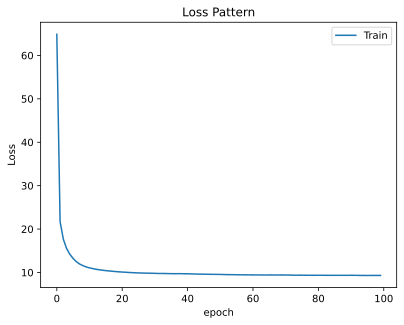

In [31]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## 3.3 Test

In [32]:
# Prediction in Train Data
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

attacks = (error_vector > error_thresh)
print(attacks)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

2023-05-05 01:32:56.103436: W tensorflow/c/c_api.cc:300] Operation '{name:'decoder/dense_2/Sigmoid' id:178 op device:{requested: '', assigned: ''} def:{{{node decoder/dense_2/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[ True  True  True ... False False False]


In [33]:
np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

0.023414614780386964

In [34]:
# Prediction in Test Data
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time: ", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks predicted

Testing time:  216.28979301452637
[False False False ...  True  True  True]


0.976530008879954

In [35]:
# Quantidade real de ataques nos dados de teste
np.count_nonzero(Y_test_VAE==1) / len(Y_test_VAE)

0.975007859493534

## 3.4 Metrics

In [36]:
target_names = ['Benign', 'Attack']

print(f" ==== Test {number_features} features - Normal learning rate ====")
print(f"Training time: {train_time / 60:.2f} min")
print(f"Testing time: {test_time / 60:.2f} min")
print(classification_report(Y_test_VAE, attacks, target_names=target_names, digits = 5))

 ==== Test 23 features - Normal learning rate ====
Training time: 40.09 min
Testing time: 3.60 min
              precision    recall  f1-score   support

      Benign    0.96140   0.90285   0.93121    166784
      Attack    0.99751   0.99907   0.99829   6506674

    accuracy                        0.99667   6673458
   macro avg    0.97946   0.95096   0.96475   6673458
weighted avg    0.99661   0.99667   0.99662   6673458



[[ 150581   16203]
 [   6045 6500629]]


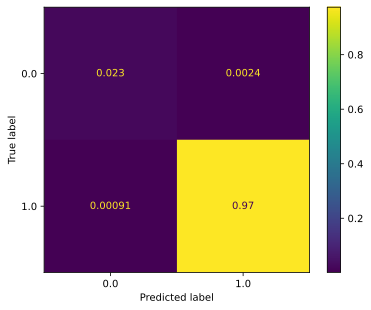

In [37]:
print(confusion_matrix(Y_test_VAE, attacks))
ConfusionMatrixDisplay.from_predictions(Y_test_VAE, attacks, normalize='all')

plt.show()

In [40]:
sys.stdout = open("./unique_model.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, target_names=target_names, digits = 5))